# AirBNB New Zealand Data Analysis Project - Introduction
### Part B - Exploratory data analysis and comparison of North Island and South Island tourist destinations

This project aims to analyze Inside Airbnb's open dataset for New Zealand and provide insights that may be useful to both consumers and hosts of Airbnb listings. The project consists of three sections: data cleaning, exploratory data analysis and followed by a detailed comparison of popular tourist destinations in the North Island and South Island.

### About the Dataset

The dataset was obtained from [Inside Airbnb](http://insideairbnb.com/). Inside Airbnb compiles public information from the official Airbnb website, including the availability calendar for 90 & 365 days in the future, and the reviews for each listing.

The data is collected through web scraping and aggregation by Inside Airbnb and is provided in a collection of CSV files. Each set of CSV files corresponds to a specific date when the data was scraped from the Airbnb website. Data scraping is conducted quarterly.

For this project, we will use the `listings.csv.gz` file, which contains detailed listings data for all publicly available listings as of 2022-12-11. This date was chosen to reflect the beginning of summer in New Zealand, allowing us to analyze a snapshot of the busiest time of the year for various holiday accommodations.

### Project Aims

The goal of this project is to utilize data that will demonstrate a range of techniques and provide actionable insights to a variety of people. The analysis will focus on answering the following questions:

1. What factors influence the distribution of price, availability, and type of Airbnb listings in popular holiday destinations in New Zealand?

2. What, if any, are the key differences between Airbnb listings in popular holiday destinations in the North and South Islands?

3. What are the features of a 'successful' Airbnb listing?

### Data Dictionary

A data dictionary covering all the fields/variables used has been made available by Inside Airbnb and can be accessed [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596).






## Section 1. Importing, cleaning and preparing data for analysis

#### 1.1 Importing packages 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats as st
import math
from pandas.api.types import CategoricalDtype
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score, mean_squared_error 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


#### 1.2 Loading and inspecting the data

In [2]:
# Importing the dataset
df = pd.read_csv('C:\Airbnb Project NZ\listings (1).csv.gz', compression='gzip')
last_scraped = pd.to_datetime(df['last_scraped'].max())
print(F" Lastest date data was scraped: {last_scraped}")

df.shape

 Lastest date data was scraped: 2022-12-10 00:00:00


(39935, 80)

In [3]:
# Selecting only relevant columns for analysis
analysis_columns = ['last_scraped', 'id','price','region_parent_name','property_type','room_type',
                    'bedrooms','host_location', 
                    'host_response_time', 'host_response_rate', 'host_acceptance_rate', 
                    'host_listings_count', 'minimum_nights', 'number_of_reviews',
                    'review_scores_rating', 'review_scores_value', 'availability_90', 
                    'availability_365', 'reviews_per_month', 'amenities', 'neighborhood_overview',
                    'instant_bookable', 'host_is_superhost', 'accommodates','host_has_profile_pic',
                     'minimum_minimum_nights','maximum_minimum_nights', 'first_review', 'host_since'
                   ]

airbnb_nz = df[analysis_columns].copy()

#### 1.3.  Adding calculated fields/variables and cleaning/inspecing the data

Because out dataset is scraped from the available information on the airbnb.co.nz website, it does not include information on the number of bookings for listing. This presents a small challenge in assessing the demand for, and hece success, of a listing. 

The dataset does include information on the number of reviews as well as figures for the average rating (across a range of 5 criteria). For the purposes of this analysis, we will create a new metric which aims to capture the success of the listing. 

Intuitively, a successful listing is one that receives a high number of highly rated reviews.The review metric is calculated using the following formula:

*Review_metric = (review_scores_value/5) * reviews_per_month*
















In [4]:

airbnb_nz['review_metric'] = \
((airbnb_nz['review_scores_value'] / 5) ** 2) * airbnb_nz['reviews_per_month'] 


In [5]:
# Removing unwanted string parts and changing relevant columns to numeric
airbnb_nz['price'] = pd.to_numeric(airbnb_nz['price'].str.replace(',', '').str.strip('$'))
airbnb_nz['host_acceptance_rate'] = pd.to_numeric(airbnb_nz['host_acceptance_rate'].str.strip('%'))
airbnb_nz['host_response_rate'] = pd.to_numeric(airbnb_nz['host_response_rate'].str.strip('%'))


# Creating a new column for the number of amenities listed for the listing.
airbnb_nz['num_amenities'] = airbnb_nz['amenities'].apply(lambda x: len(eval(x)))

airbnb_nz['first_review'] = pd.to_datetime(airbnb_nz['first_review'])
airbnb_nz['last_scraped'] = pd.to_datetime(airbnb_nz['last_scraped'])
airbnb_nz['host_since'] = pd.to_datetime(airbnb_nz['host_since'])
airbnb_nz['days_listed'] = (airbnb_nz['last_scraped'] - airbnb_nz['first_review']).dt.days
airbnb_nz['days_listed'] = airbnb_nz['days_listed'].fillna(0)
airbnb_nz['days_listed'].value_counts()
airbnb_nz['days_since_host_joined'] = (airbnb_nz['last_scraped'] - airbnb_nz['host_since']).dt.days
# Checking the shape of our data
airbnb_nz.shape

(39935, 33)

In [6]:
# Checking value ranges and looking for outliers
airbnb_nz.describe()

,id,price,bedrooms,host_response_rate,host_acceptance_rate,host_listings_count,minimum_nights,number_of_reviews,review_scores_rating,review_scores_value,availability_90,availability_365,reviews_per_month,accommodates,minimum_minimum_nights,maximum_minimum_nights,review_metric,num_amenities,days_listed,days_since_host_joined
count,3.993500e+04,39935.000000,37876.000000,33211.000000,35127.000000,39935.000000,39935.000000,39935.000000,34484.000000,34388.000000,39935.000000,39935.000000,34484.000000,39935.000000,39935.000000,39935.000000,34388.000000,39935.000000,39935.000000,39935.000000
mean,1.273146e+17,394.625191,2.164194,95.586553,89.188345,131.441442,3.040140,48.330061,4.787850,4.737518,35.728534,156.598923,1.538250,4.513509,2.597396,4.020133,1.426326,32.251684,989.199649,2046.830925
std,2.623448e+17,2697.705983,1.274620,14.181630,21.345166,508.575473,23.956798,82.466457,0.400435,0.353287,29.305208,122.954511,1.760803,2.784655,16.519584,27.514324,1.660692,14.747596,818.633427,853.700809
min,6.113000e+03,14.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000
25%,2.294446e+07,118.000000,1.000000,100.000000,91.000000,1.000000,1.000000,3.000000,4.750000,4.670000,7.000000,35.000000,0.320000,2.000000,1.000000,1.000000,0.287104,21.000000,206.000000,1519.000000
50%,3.995286e+07,189.000000,2.000000,100.000000,98.000000,2.000000,2.000000,15.000000,4.890000,4.830000,33.000000,152.000000,0.950000,4.000000,2.000000,2.000000,0.860000,31.000000,976.000000,2088.000000
75%,5.147946e+07,305.000000,3.000000,100.000000,100.000000,5.000000,2.000000,57.000000,4.992500,4.940000,59.000000,276.000000,2.110000,6.000000,2.000000,3.000000,1.966666,43.000000,1585.000000,2569.000000
max,7.553782e+17,140155.000000,15.000000,100.000000,100.000000,2226.000000,1122.000000,1337.000000,5.000000,5.000000,90.000000,365.000000,35.810000,16.000000,1122.000000,1122.000000,30.441508,98.000000,4244.000000,5186.000000


Looking at the 5 number summary for each variable, there appear to be problematic outliers in the price column. With a mean listing price of around 350 per night, the maximum value of nearly 170,000 a night will create problems for any models or charts. In fact there are a number of very high prices which are over 10,000 a night. After inspecting these listings manually, it is clear that these values should not be part of our analysis. 

For the sake of simplicity, we will remove all rows where price is above the 99th percentile.



In [7]:
airbnb_nz = airbnb_nz[(airbnb_nz['price'] < airbnb_nz['price'].quantile(0.99))]

                     


In [8]:
# Checking the distribution of N/A values in the dataset
airbnb_nz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39535 entries, 0 to 39934
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   last_scraped            39535 non-null  datetime64[ns]
 1   id                      39535 non-null  int64         
 2   price                   39535 non-null  float64       
 3   region_parent_name      39535 non-null  object        
 4   property_type           39535 non-null  object        
 5   room_type               39535 non-null  object        
 6   bedrooms                37487 non-null  float64       
 7   host_location           32807 non-null  object        
 8   host_response_time      32861 non-null  object        
 9   host_response_rate      32861 non-null  float64       
 10  host_acceptance_rate    34791 non-null  float64       
 11  host_listings_count     39535 non-null  int64         
 12  minimum_nights          39535 non-null  int64 

#### 1.4 Selecting Categorical variables of interest and assigning them logical order.

In [9]:
categorical_columns = ['bedrooms', 'room_type', 'host_reponse_time',
'num_bedrooms']

# Creating a categorical column for number of bedrooms from 1 - 6+ (for visualization)
def bedrooms_cat(bedrooms):
    if bedrooms > 0 and bedrooms < 6:
        return str(bedrooms)
    elif bedrooms >= 6: 
        return '6+'
    else:
        return 'not specified'
    
bedrooms_order = ['1', '2', '3', '4', '5', '6+', 'not specified']
airbnb_nz['num_bedrooms'] = airbnb_nz['bedrooms'].apply(bedrooms_cat).str.strip('.0')
category_dtype = CategoricalDtype(categories=bedrooms_order, ordered=True)
airbnb_nz['num_bedrooms'] = airbnb_nz['num_bedrooms'].astype(category_dtype)


# Creating a categorical column for room_type
room_type_order = ['Shared room', 'Hotel room','Private room', 'Entire home/apt']
category_dtype = CategoricalDtype(categories=room_type_order, ordered=True)
airbnb_nz['room_type'] = airbnb_nz['room_type'].astype(category_dtype)

# Creating a categorical column for host_response_time
host_response_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
category_dtype = CategoricalDtype(categories = host_response_order, ordered = True)
airbnb_nz['host_response_time'] = airbnb_nz['host_response_time'].astype(category_dtype)
airbnb_nz['host_response_time_cat'] = airbnb_nz['host_response_time'].cat.codes.replace(-1, np.nan)

# Section 2. Exploratory data analysis for NZ-Wide Data

#### 2.1 Looking at broad distribution of listings based on location, price and property type

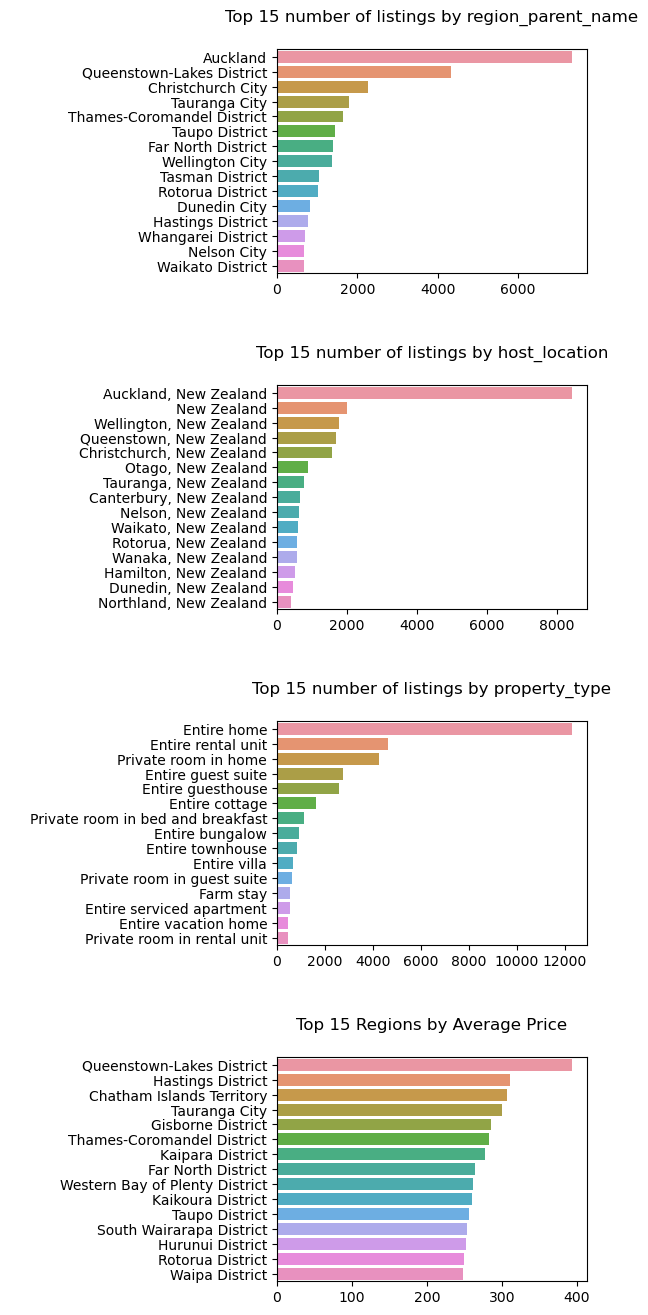

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of variables with many categorical values
top15 = ['region_parent_name', 'host_location', 'property_type']

# Create subplots 
fig, axes = plt.subplots(4, 1, figsize=(4, 16), gridspec_kw={'hspace': 0.5})

# Plot the top 15 values for each variable
idx = 0
for t in top15:
    # Group the data and select the top 15 values
    df3 = airbnb_nz.groupby(t)['id'].count().to_frame('number of listings')\
                   .reset_index().sort_values('number of listings', ascending=False).head(15)
    
    axes[idx].set_title('Top 15 number of listings by ' + t, pad=20)
    
    # Ploting the chart
    sns.barplot(y=df3[t], x=df3['number of listings'], ax=axes[idx])
    axes[idx].set_ylabel(' ')
    axes[idx].set_xlabel(' ')
    axes[idx].tick_params(axis='y', labelsize=10)
    idx += 1

# Grouping to find average price
top15_average_price = airbnb_nz.groupby('region_parent_name')['price'].mean()\
                               .to_frame('avg_price').sort_values('avg_price', ascending=False)\
                               .reset_index().head(15)
sns.barplot(y=top15_average_price['region_parent_name'], x=top15_average_price['avg_price'], 
            ax=axes[3])

# Set the title and adjust axis labels and tick sizes for the last subplot
plt.title('Top 15 Regions by Average Price', pad=20)
axes[3].tick_params(axis='y', labelsize=10)
axes[3].set_xlabel('')
axes[3].set_ylabel('')

# Display the plots
plt.show()


#### Observations:

#### Region:

* Auckland has the largest number of listings by a considerable margin (Close to 8000 listings).

* Queenstown has the largest number of listings in the South Island by a considerable margin (~4000+ listings).

#### Host Location:

* Proportionally more hosts are from Auckland than there are listings in Auckland. One possible explanation for this is that Aucklander's have a propensity to own a second property/batch and list in on Airbnb.

#### Property Type

* A large portion of listings are entire homes and there is a variety of part-of-home listings

#### Average Price

* Queenstown is a bit of an outlier for average price, with other popular tourist districts being less spread out.



# Section 3 - Comparative analysis of North Island vs South Island holiday locations

In this section I create two distinct groups from the Airbnb Listings data: North Island holiday destinations and South Island holiday destinations.

The groups were constructed with the aim of having a similar number of observations, and representing the N most popoular regions for travel/tourism. 

Due to Queenstown being an outlier in terms of both number of listings as well as price, it has been excluded from the South Island group. Large urban cities where many Airbnb Guests may be on work trips or attending events were not counted.

Some juggling of groups was necessary in order to create representative groups of the same size.

The groups are as follows:

#### North Island

* Thames-Coromandel District
* Taupo District
* Rotorua District
* Western Bay of Plenty District
* Ruapehu District

#### South Island

* Tasman District
* Nelson City
* Mackenzie District
* Marlborough District 
* Central Otago District
* Southland District 
* Hurunui District
* Kaikoura District
* Selwyn District
* Clutha District
* Westland District

#### 3.1 Creating groups

In [11]:
airbnb_nz['region_parent_name'].value_counts().head(25)

Auckland                          7347
Queenstown-Lakes District         4339
Christchurch City                 2276
Tauranga City                     1796
Thames-Coromandel District        1635
Taupo District                    1441
Far North District                1401
Wellington City                   1372
Tasman District                   1057
Rotorua District                  1013
Dunedin City                       825
Hastings District                  770
Whangarei District                 693
Nelson City                        682
Waikato District                   678
Mackenzie District                 674
New Plymouth District              662
Ruapehu District                   640
Western Bay of Plenty District     618
Marlborough District               596
Southland District                 588
Napier City                        575
Hamilton City                      521
Central Otago District             464
Kapiti Coast District              423
Name: region_parent_name,

In [12]:
queenstown_sample = airbnb_nz[airbnb_nz['region_parent_name'] == 'Queenstown-Lakes District'].sample(1650, random_state = 0)
not_queenstown = airbnb_nz[airbnb_nz['region_parent_name'] != 'Queenstown-Lakes District']
airbnb_nz = pd.concat([not_queenstown, queenstown_sample], axis = 0)

In [13]:
# North Island Group
group_a = ['Thames-Coromandel District', 
           'Taupo District', 
           'Rotorua District', 
           'Western Bay of Plenty District', 
           'Hastings District',
           'Gisborne District']

# South Island Group
group_b = ['Queenstown-Lakes District',
           'Tasman District', 
           'Nelson City', 
           'Mackenzie District', 
           'Marlborough District', 
           'Central Otago District', 
           'Southland District']

# North island df
north_island = airbnb_nz[airbnb_nz['region_parent_name'].isin(group_a)].reset_index().drop(columns =
'index').copy()

# South island df
south_island = airbnb_nz[airbnb_nz['region_parent_name'].isin(group_b)].reset_index()\
.drop(columns = 'index').copy()

# Creating labels for concatenated dataframe
north_island['group'] = 'north_island'
south_island['group'] = 'south_island'

# Creating one dataframe for both groups
groups = pd.concat([north_island, south_island], axis = 0)
print('Number of listings for north_island: ' + str(north_island.shape[0]))
print('Number of listings for South Island: ' + str(south_island.shape[0]))



Number of listings for north_island: 5782
Number of listings for South Island: 5711


In [14]:
print(groups[groups['group'] == 'south_island']['region_parent_name'].value_counts())
print(groups[groups['group'] == 'north_island']['region_parent_name'].value_counts())

Queenstown-Lakes District    1650
Tasman District              1057
Nelson City                   682
Mackenzie District            674
Marlborough District          596
Southland District            588
Central Otago District        464
Name: region_parent_name, dtype: int64
Thames-Coromandel District        1635
Taupo District                    1441
Rotorua District                  1013
Hastings District                  770
Western Bay of Plenty District     618
Gisborne District                  305
Name: region_parent_name, dtype: int64


#### 3.2 Comparison of distribution of price, 90-day  forward looking availability and review_metric

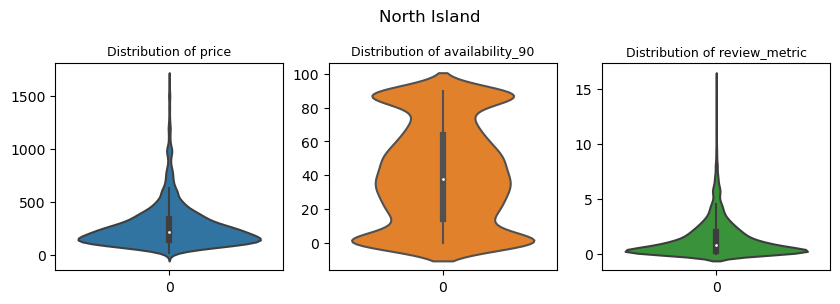

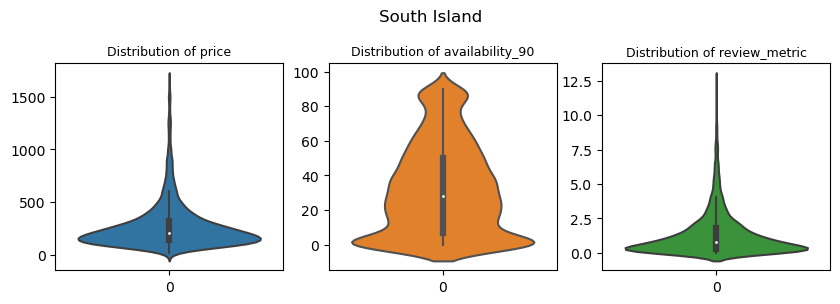

In [15]:
violinplots1 = ['price', 'availability_90', 'review_metric']

colors1 = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plotting violinplots
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
idx = 0

for v, c in zip(violinplots1, colors1):
    plt.suptitle('North Island')
    sns.violinplot(north_island[v], ax=axes[idx], color=c)
    axes[idx].set_title('Distribution of ' + v, fontsize=9)
    idx += 1
    
plt.subplots_adjust(top=0.8)

fig.set_size_inches(10, 3)  

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
idx = 0

for v, c in zip(violinplots1, colors1):
    plt.suptitle('South Island')
    sns.violinplot(south_island[v], ax=axes[idx], color=c)
    axes[idx].set_title('Distribution of ' + v, fontsize=9)
    idx += 1

fig.set_size_inches(10, 3)  
plt.subplots_adjust(top=0.8)
            

Observations

#### Price:

* Similar shaped distribution for both north and south, Right skew. North island has greater proportion of listings above 300 dollars a night.

#### 90 Day Availability of listing  
(Number of days the listing was available over the next 90 days at time of scrape)
* North Island has a U - shaped/ Bimodal distribution. Large number of listings with near full availability or no availablility over next 90 days.

* South Island has a comparatively larger mode near 0 days of availabity, suggesting that many of the most desirable listings have been snapped up by early december.

* North Island listings generally have more availability at this time of year.

#### Review Metric

* North and South islands have a similar distribution. Right skew.

#### 3.3 Comparison of distribution of host response rate, host acceptance rate and average review scores


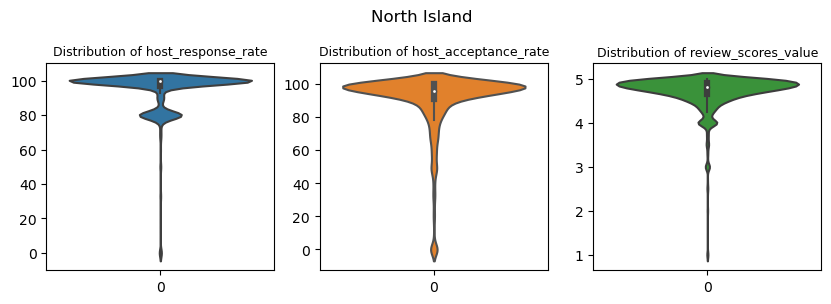

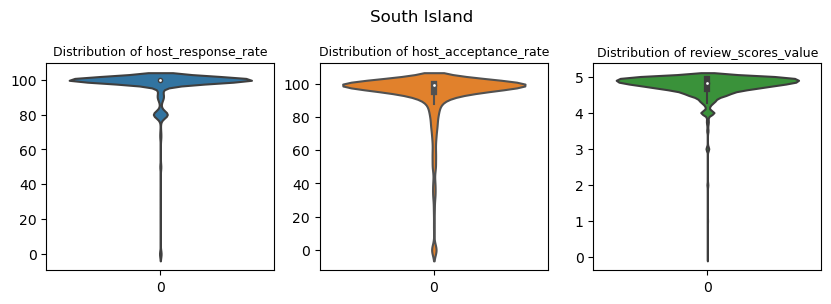

In [16]:
violinplots2 = ['host_response_rate', 'host_acceptance_rate', 'review_scores_value']
colors2 = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
idx = 0

for v, c in zip(violinplots2, colors2):
    plt.suptitle('North Island')
    sns.violinplot(north_island[v], ax=axes[idx], color=c)
    axes[idx].set_title('Distribution of ' + v, fontsize=9)
    idx += 1
    
plt.subplots_adjust(top=0.8)

fig.set_size_inches(10, 3)  # Set the figure size

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
idx = 0

for v, c in zip(violinplots2, colors2):
    plt.suptitle('South Island')
    sns.violinplot(south_island[v], ax=axes[idx], color=c)
    axes[idx].set_title('Distribution of ' + v, fontsize=9)
    idx += 1

fig.set_size_inches(10, 3)  # Set the figure size
plt.subplots_adjust(top=0.8)


Observations: Similar distributions for all 3 variables. Strong left skew centered around maximum value

#### 3.4 Comparing distributions of Room Type

C:\Users\james\AppData\Local\Temp\ipykernel_27996\3762300162.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment = 'right')
C:\Users\james\AppData\Local\Temp\ipykernel_27996\3762300162.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment = 'right')


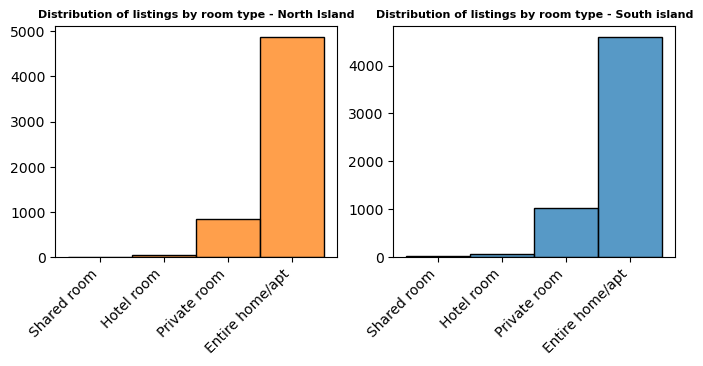

In [17]:
hist = ['room_type', 'num_bedrooms', 'review_scores_rounded']

fig, axes = plt.subplots(1,2, figsize = (8,3))
sns.histplot(north_island['room_type'], ax = axes[0], color = '#ff7f0e')
axes[0].set_title('Distribution of listings by room type - North Island', fontsize = 8, fontweight = 'bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment = 'right')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

sns.histplot(south_island['room_type'], ax = axes[1])
axes[1].set_title('Distribution of listings by room type - South island', fontsize = 8, fontweight = 'bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment = 'right')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
plt.show()

Observations: Similar distribution, South island has proportionately more private rooms.


#### 3.5 Comparing distributions of number of rooms of listings

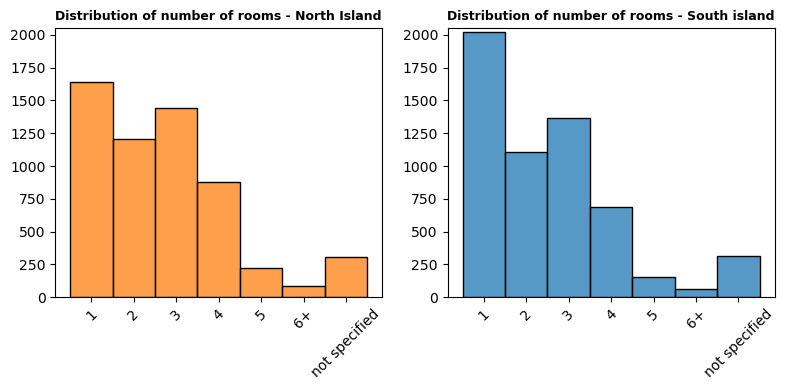

In [18]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot for North Island
sns.histplot(north_island['num_bedrooms'], ax=axes[0], color='#ff7f0e')
axes[0].set_title('Distribution of number of rooms - North Island', fontsize=9, fontweight = 'bold')
axes[0].set_xticks(range(len(axes[0].get_xticklabels())))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_ylim([0, 2050])  # Set y-axis limits

# Plot for South Island
sns.histplot(south_island['num_bedrooms'], ax=axes[1])
axes[1].set_title('Distribution of number of rooms - South island', fontsize=9, fontweight = 'bold')
axes[1].set_xticks(range(len(axes[0].get_xticklabels())))
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim([0, 2050])  # Set y-axis limits

plt.tight_layout()
plt.show()


Obervations: South island proportionately has more 1 bedroom listings while North Island's distribtution of listings by room numbers is more evenly distributed between 1-4 bedroom listings.


#### 3.6 Relationship between number of bedrooms, price and number of reviews

<Figure size 640x480 with 0 Axes>

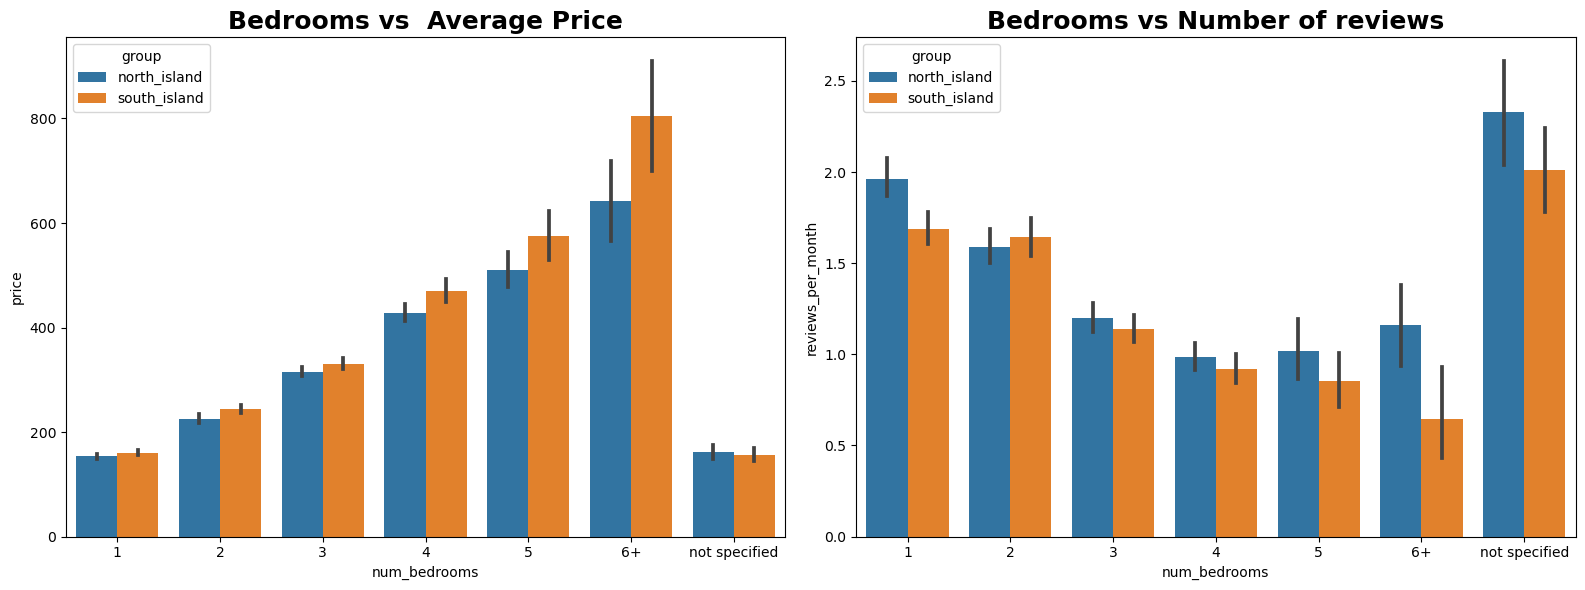

In [19]:
plt.suptitle('')
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Bedrooms vs  Average Price', fontsize = 18, fontweight = 'bold')
ax1.set_xlabel('')
sns.barplot(data=groups, x='num_bedrooms', y='price', hue='group', ax=ax1)

# Creating a dataframe for 4.8 star average and above only

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Bedrooms vs Number of reviews', fontsize = 18, fontweight = 'bold')
ax2.set_xlabel('')
ax2.set_ylabel('Avg Review metric $')
sns.barplot(data=groups, x='num_bedrooms', y='reviews_per_month', hue='group', ax=ax2)

plt.tight_layout()
plt.show(gs)



Observations

#### Number of bedrooms vs Price
* Strong positive correlation as expected.
* For one and two bedroom listings, average price was virtually identical for North and South Island.
* For three to four bedroom listings, average prices were noticably higher (10-20%) in the North Island.
* Where the number of bedrooms is not specified, listing appear to be priced similarly to 1 bedroom listings.

#### Number of 5 star reviews and Price
* Negative correlation. This is likely because the average review score is very high, and cheaply priced listings likely receive the most bookings.
* Two, Three and four bedroom listings in the South Island receive more reviews than in the North Island group. 
* There is some evidence that the number of reviews and by extension frequency of bookings is negatively correlated with  the number of bedrooms and price. This should be investigated further.
* **Listings where the number of bedrooms is not specified appear to be quite popular. This should be investigated further.**

#### 3.6A Investigating listings where number of bedrooms is N/A.

Listings where the number of bedrooms was N/A, have the greatest number of average reviews of any bedroom category. For both the North and South Islands, they are priced similarly to 1 bedroom accommodation on average.

Let's investigate this group of listings by inspecting the most common property types.

In [20]:
groups[groups['bedrooms'].isna()]['property_type'].value_counts().head(10)

Entire guest suite             135
Entire guesthouse              128
Entire rental unit              59
Room in hotel                   33
Tiny home                       27
Entire home                     20
Entire cabin                    17
Entire cottage                  16
Private room in guesthouse      16
Private room in guest suite     15
Name: property_type, dtype: int64

Observation: N/A Bedroom values appear to be from niche studio-type properties such as guesthouses, guest suits, tiny homes and cabins.

Collectively guesthouses, guest suits, cabins, tiny homes, chalets and other non conventional accommodations are priced reasonably low and are very popular based on the number of good reviews they recieve.

Lets create a new binary variable, 'studio/niche_property_type' to capture what we have observed.


In [21]:
def is_niche(x):
    if x == 'not specified':
        return 1
    else:
        return 0
groups['Studio/niche_property_type'] = groups['num_bedrooms'].apply(is_niche)


#### 3.7 Relationship between average availability for booking over the next 90 days with number of bedrooms

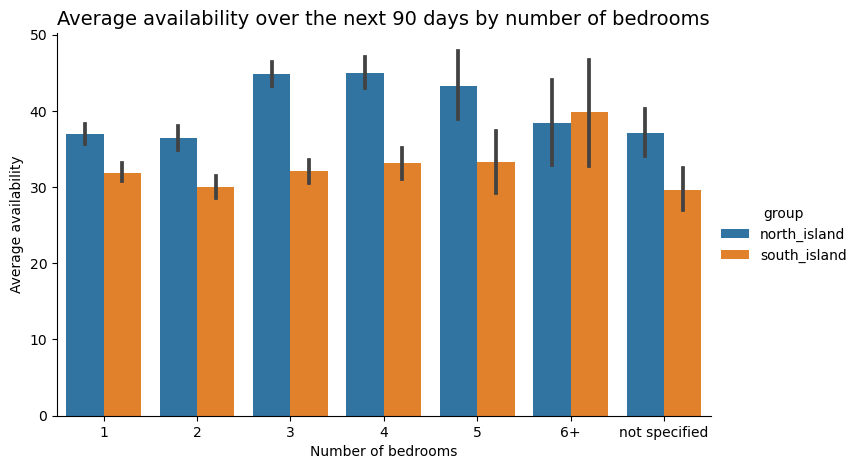

In [22]:
ax = sns.catplot(data=groups, 
                 x='num_bedrooms', 
                 y='availability_90', 
                 kind='bar', 
                 hue='group', 
                 height=4.6, 
                 aspect=1.6
                )
plt.title('Average availability over the next 90 days by number of bedrooms', fontsize = 14)
plt.xlabel('Number of bedrooms')
plt.ylabel('Average availability')
plt.show()



#### Observations & Insights
* South Island has less availability on average across all listing sizes.

* The disparity in availability of listings between North and South island is largest for 3 - 5 bedroom accommodations.

* For 3 - 5 bedroom accommodation, listings in The North Island tend to have higher prices, fewer reviews and more availability.

* If you want to book accommodation in the South Island, you should book early. Less time in advance is likely needed on average for North Island locations.

* The differences in price, availability and reviews between the North and South Islands are much less significant for 1 & 2 bedroom accommodation.

#### 3.8 Investigating the relationship between price, review metric and region.

Based on the analysis above, it seems likely that there is a negative relationsip between price and review metric. Due to the relatively low variance in the review ratings (Section 3.2), this is suggestive that listings with higher prices tend to recieve fewer bookings.

Let's further visualize this relationship by plotting price vs review metric, and adding a hue for region in order to assess if any regions stand out.


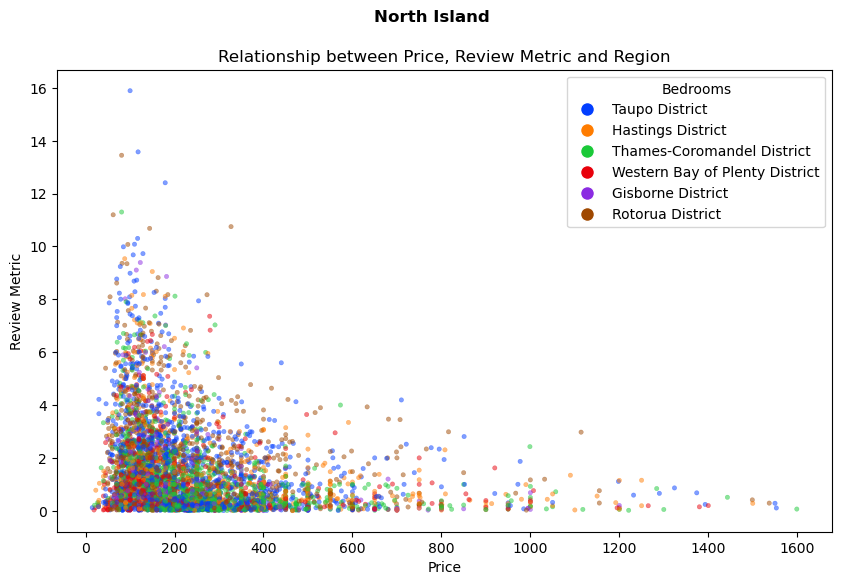

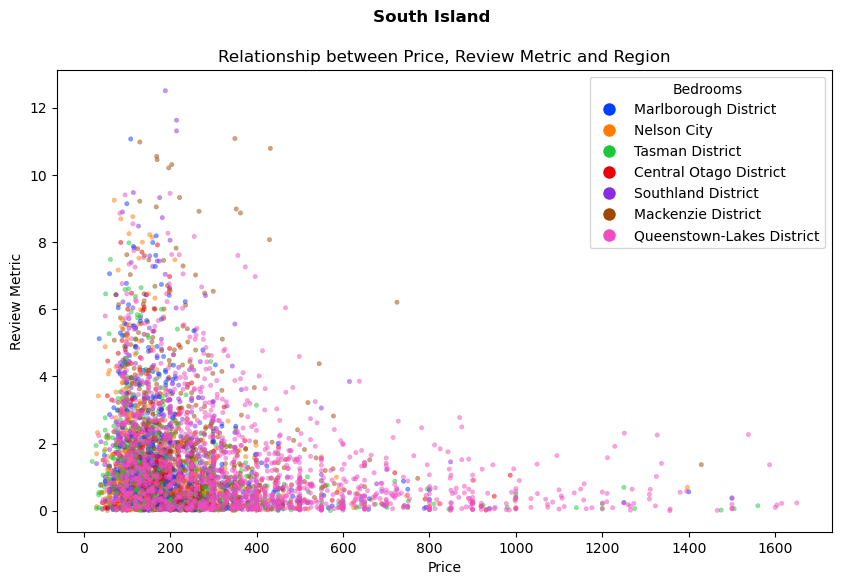

In [23]:
# Creating a color-district key
districts = list(north_island['region_parent_name'].unique())
colors = sns.color_palette('bright', n_colors=len(districts))
district_color_map = dict(zip(districts, colors))

#Plotting the figures
plt.figure(figsize = (10,6))
plt.scatter(x=north_island['price'], y=north_island['review_metric'], linewidth=0.3, marker='o',
            s=10, c=north_island['region_parent_name'].map(district_color_map), alpha = 0.5)

# Add a color legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=district, markerfacecolor=color,
                   markersize=10) for district, color in district_color_map.items()]

plt.legend(handles=legend_elements, title='Bedrooms')

plt.xlabel('Price')
plt.ylabel('Review Metric')
plt.suptitle('North Island', fontweight = 'bold')
plt.title('Relationship between Price, Review Metric and Region')

plt.show()

districts = list(south_island['region_parent_name'].unique())
colors = sns.color_palette('bright', n_colors=len(districts))

district_color_map = dict(zip(districts, colors))

plt.figure(figsize = (10,6))
plt.scatter(x=south_island['price'], y=south_island['review_metric'], linewidth=0.3, marker='o',
            s=10, c=south_island['region_parent_name'].map(district_color_map), alpha = 0.5)

# Add a color legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=district, markerfacecolor=color,
                   markersize=10) for district, color in district_color_map.items()]
plt.legend(handles=legend_elements, title='Bedrooms')

plt.xlabel('Price')
plt.ylabel('Review Metric')
plt.suptitle('South Island', fontweight = 'bold')
plt.title('Relationship between Price, Review Metric and Region')

plt.show()

Observations: 

* As hypothesized there is a relatively significant negative relationship between price and review metric. 
* The relationship appears to be nonlinear.
* There is some visible clustering, but in general the relationship between price and review metric for each region is similar, with the number of high quality reviews decreasing as price increases.
* For the South Island Group, listings in the Mackenzie district appear to have both higher prices and review metric than average.

## 4. Identifying what host and listing characteristics contribute towards listing success (Random Forrest Regression).

For a prospective host of an Aibnb listing, it would be of interest to know what characteristics a 'successful' listing has. Due to the difficulty in calculating financial metrics such as ROI due to the dataset being void of any addresses or property information, we will define a successful listing using the review_metric feature we engineered earlier.

A random forrest regression model was chosen to evaluable feature importance of variables in order to predict the success of the listing measured by our review metric.

Random forrest regression was selected due to the relatively strong nonlinear relationship observed 
between price and review metric, as well as its overall versatility and ability to manage the effects of collinearity. 


#### 4.1 Variable selection. 
Selecting numeric variables and creating dummy variables for categorical variables which may be correlated with listing success (review_metric).

In [24]:
# Selecting variables for our model.


feature_importance_model = groups[['price', 'bedrooms', 'host_response_rate', 'host_acceptance_rate',
                                 'host_response_time','review_metric', 'group', 'num_amenities',
                                 'host_is_superhost', 'accommodates', 'availability_365', 'room_type', 
                                  'minimum_minimum_nights','maximum_minimum_nights', 'days_listed', 
                                   'days_since_host_joined',  'minimum_nights']].copy()

# Creating dummy variables for categorical variables using one-hot encoding.
dummy_variables =  ['host_response_time',
                    'host_is_superhost', 'room_type']

response_1hour_dummy = pd.get_dummies(groups['host_response_time'], prefix = 'host_response_time', 
                                          prefix_sep = ': ').iloc[:, 0]
superhost_dummy = pd.get_dummies(groups['host_is_superhost'], prefix = 'host_is_superhost', 
                                          prefix_sep = ': ').iloc[:, 1]
room_type_dummies = pd.get_dummies(groups['room_type'], prefix = 'room_type ', prefix_sep = ':')\
.iloc[:, -1]

feature_importance_model = feature_importance_model.drop(dummy_variables, axis=1)


In [25]:
# Adding dummy variables to feature importance data

feature_importance = pd.concat([feature_importance_model, 
                                response_1hour_dummy,
                                superhost_dummy,
                        
                                room_type_dummies], axis = 1)



In [26]:
# Removing rows where review_metric is N/A (Has not received at least 1 review)
feature_importance = feature_importance.dropna(subset = ['review_metric'], axis = 0)

# Imputing remaining N/A values with averages for each variable.
for c in feature_importance.select_dtypes(include=np.number).columns.tolist():
    feature_importance[c].fillna((feature_importance[c].mean()), inplace=True)

# North island data
n = feature_importance[feature_importance['group'] == 'north_island'].drop(columns = ['group']).copy()
# South Island Data
s = feature_importance[feature_importance['group'] == 'south_island'].drop(columns = ['group']).copy()

#### 4.2 Correlation matrix/heatmap(s).

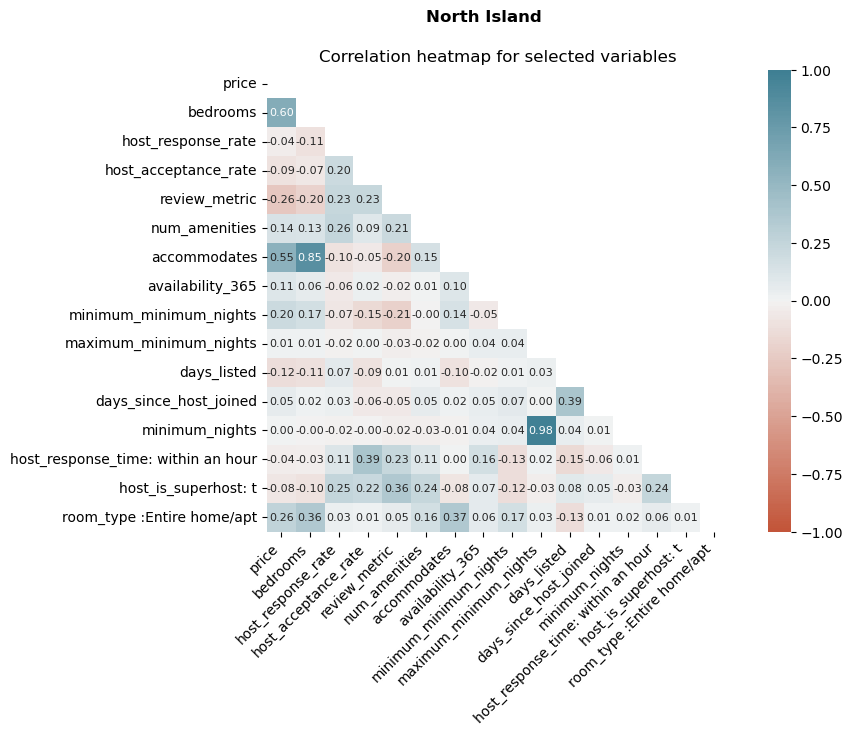

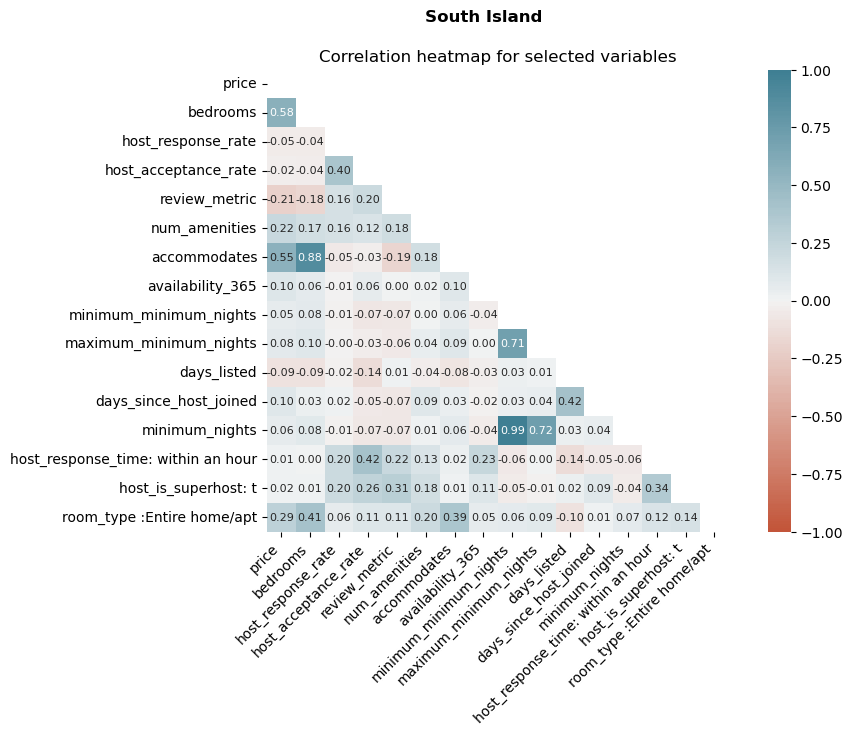

In [27]:
import numpy as np

def create_heatmap(df, title):
    corr = df.corr(numeric_only=True)
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    plt.figure(figsize=(10,6))
    plt.suptitle(title, fontweight='bold')
    plt.title('Correlation heatmap for selected variables')

    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot=True,
        fmt=".2f",
        annot_kws={"fontsize": 8},
        mask=mask  # apply the mask to the heatmap
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.show()

create_heatmap(n, 'North Island')
create_heatmap(s, 'South Island')


#### 4.3 Creating a model to identify important host and listing features for predicting the success of a listing.





In [28]:
# Creating dependent and independent variables
y_n = n['review_metric']
X_n = n.drop(columns = ['review_metric'])

y_s = s['review_metric']
X_s = s.drop(columns = ['review_metric'])

#Splitting the training set and test set  
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size =0.2, random_state=43)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size =0.2, random_state=5)

# Initialize the StandardScalers
sc_n = StandardScaler()
sc_s = StandardScaler()

# Fit the StandardScaler on the training data and transform the training data
X_train_n = sc_n.fit_transform(X_train_n)
X_train_s = sc_s.fit_transform(X_train_s)

# Use the respective StandardScaler to transform the test data
X_test_n = sc_n.transform(X_test_n)
X_test_s = sc_s.transform(X_test_s)



In [29]:
# # # Tuning Hyperparameters

# # Parameters for testing
# param_grid = {
#     'max_depth': [5, 7, 10, 12],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [50, 75, 85, 95]
# }

# # Create a base model
# rf = RandomForestRegressor(criterion='friedman_mse', random_state=1, n_jobs=-1)

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=3, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search.fit(X_train_s, y_train_s.squeeze())

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")


In [30]:
#Building the regressor and fitting the dataset

#North Island Regressor
regressor_n = RandomForestRegressor(n_estimators=95, 
                                    max_depth=12,  
                                    min_samples_split=2,   
                                    criterion='friedman_mse', 
                                    random_state=42, 
                                    n_jobs=-1)
                                
regressor_n.fit(X_train_n, y_train_n.squeeze())


#South Island Regressor
regressor_s = RandomForestRegressor(n_estimators=95, 
                                    max_depth=12,  
                                    min_samples_split=2,  
                                    criterion='friedman_mse', 
                                    random_state=42, 
                                    n_jobs=-1)

regressor_s.fit(X_train_s, y_train_s.squeeze())

RandomForestRegressor(criterion='friedman_mse', max_depth=12, n_estimators=95,
                      n_jobs=-1, random_state=42)

In [31]:
#Model accuracties and validation analysis
#Seattle
y_train_n_preds = regressor_n.predict(X_train_n)
y_test_n_preds = regressor_n.predict(X_test_n)
y_train_s_preds = regressor_s.predict(X_train_s)
y_test_s_preds = regressor_s.predict(X_test_s)

print("North Island RF Accuracies")
print("Random Forest MSE train: %.3f, test: %.3f" % (mean_squared_error(y_train_n, y_train_n_preds),
                                                     mean_squared_error(y_test_n, y_test_n_preds)))
print("Random Forest R^2 train: %.3f, test: %.3f" % (r2_score(y_train_n, y_train_n_preds),
                                                     r2_score(y_test_n, y_test_n_preds)))
print('-----------------------------------------------------')

print("South Island RF Accuracies")
print("Random Forest MSE train: %.3f, test: %.3f" % (
    mean_squared_error(y_train_s, y_train_s_preds), 
    mean_squared_error(y_test_s, y_test_s_preds)
    ))
print("Random Forest R^2 train: %.3f, test: %.3f" % (
    r2_score(y_train_s, y_train_s_preds),
    r2_score(y_test_s, y_test_s_preds)
    ))
print('-----------------------------------------------------')


North Island RF Accuracies
Random Forest MSE train: 0.397, test: 1.589
Random Forest R^2 train: 0.855, test: 0.461
-----------------------------------------------------
South Island RF Accuracies
Random Forest MSE train: 0.418, test: 1.572
Random Forest R^2 train: 0.828, test: 0.434
-----------------------------------------------------


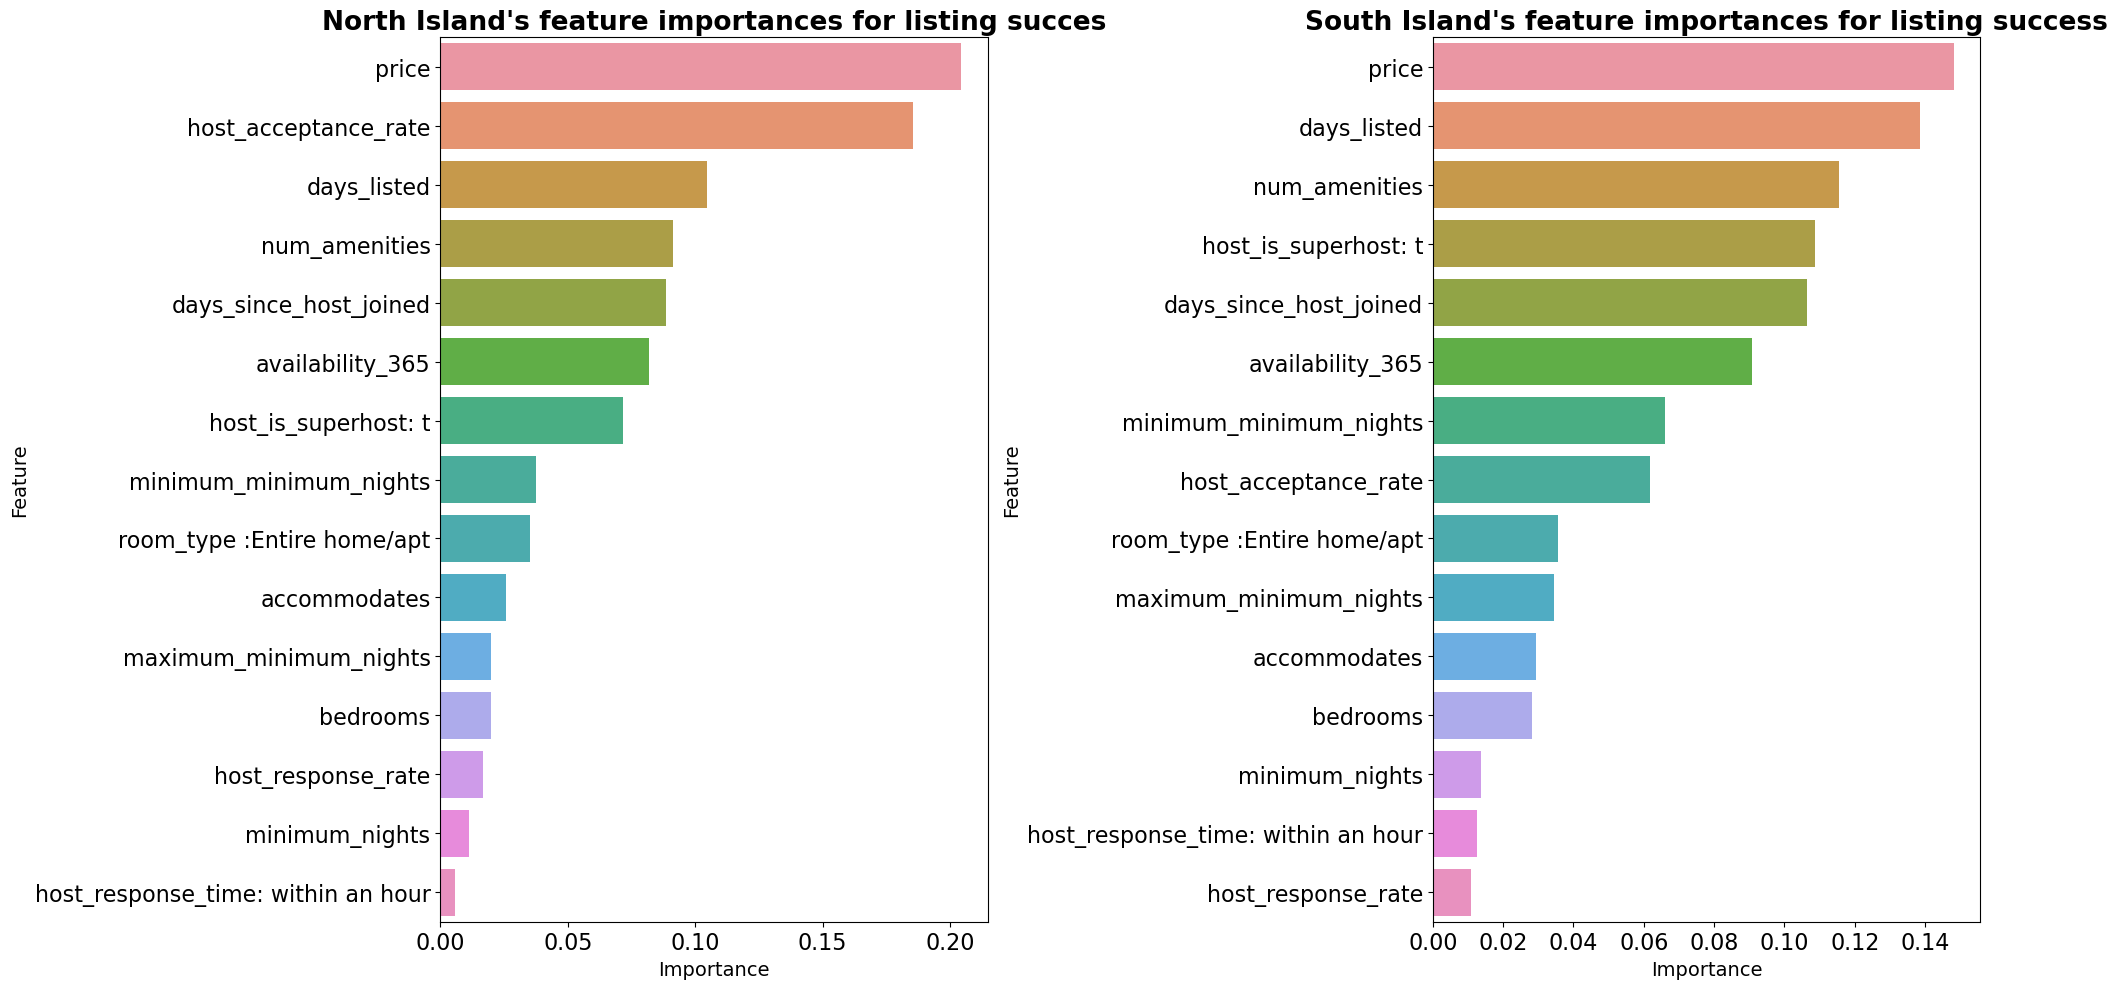

In [32]:
importances_n = regressor_n.feature_importances_
feat_names_n = X_n.columns
tree_result_n = pd.DataFrame({'feature': feat_names_n, 'importance': importances_n})
tree_result_sort_n = tree_result_n.sort_values(by='importance',ascending=False)

importances_s = regressor_s.feature_importances_
feat_names_s = X_s.columns
tree_result_s = pd.DataFrame({'feature': feat_names_s, 'importance': importances_s})
tree_result_sort_s = tree_result_s.sort_values(by='importance',ascending=False)

# create a figure and a grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# plot the first subplot
sns.barplot(x='importance', y='feature', data=tree_result_sort_n, ax=ax[0])
ax[0].set_title("North Island's feature importances for listing succes", fontsize = 19, 
                fontweight = 'bold')
ax[0].set_xlabel('Importance', fontsize=14)
ax[0].set_ylabel('Feature', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=16)

# plot the second subplot
sns.barplot(x='importance', y='feature', data=tree_result_sort_s, ax=ax[1])
ax[1].set_title("South Island's feature importances for listing success", fontsize = 19, 
                fontweight = 'bold')
ax[1].set_xlabel('Importance', fontsize=14)
ax[1].set_ylabel('Feature', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=16)

# improve layout and prevent overlapping plot elements
plt.tight_layout()
plt.show()
